# Scratch with loaded model

In [1]:
from copy import deepcopy
from pathlib import Path
import torch

from twm.replay_buffer import ReplayBuffer
from twm.config import CONFIGS

## Load

In [2]:
# get the latest save
saves = list(Path('../wandb/').glob('**/agent_*.pt'))
saves = sorted(saves, key=lambda x: x.stat().st_mtime)
print(saves)
save = saves[-1]

save = Path('../wandb/run-20240601_113918-ctz0yebk/files/files/agent_final.pt')
save


[PosixPath('../wandb/run-20240601_075812-0l0foh9u/files/agent_0.pt'), PosixPath('../wandb/run-20240601_075812-0l0foh9u/files/files/agent_0.pt'), PosixPath('../wandb/run-20240601_075812-0l0foh9u/files/agent_10000.pt'), PosixPath('../wandb/run-20240601_075812-0l0foh9u/files/files/agent_10000.pt'), PosixPath('../wandb/run-20240601_075812-0l0foh9u/files/agent_20000.pt'), PosixPath('../wandb/run-20240601_075812-0l0foh9u/files/files/agent_20000.pt'), PosixPath('../wandb/run-20240601_075812-0l0foh9u/files/agent_30000.pt'), PosixPath('../wandb/run-20240601_075812-0l0foh9u/files/files/agent_30000.pt'), PosixPath('../wandb/run-20240601_075812-0l0foh9u/files/agent_40000.pt'), PosixPath('../wandb/run-20240601_075812-0l0foh9u/files/files/agent_40000.pt'), PosixPath('../wandb/run-20240601_075812-0l0foh9u/files/agent_50000.pt'), PosixPath('../wandb/run-20240601_075812-0l0foh9u/files/files/agent_50000.pt'), PosixPath('../wandb/run-20240601_075812-0l0foh9u/files/agent_final.pt'), PosixPath('../wandb/ru

PosixPath('../wandb/run-20240601_113918-ctz0yebk/files/files/agent_final.pt')

In [3]:
state = torch.load(save)
print(state.keys())
config = state['config']
config['model_device'] = 'cpu'

dict_keys(['config', 'state_dict'])


In [4]:
from twm.trainer import Trainer
trainer = Trainer(config)
trainer.agent.load_state_dict(state['state_dict'])
trainer.agent.eval()
agent = trainer.agent
agent

/media/wassname/SGIronWolf/projects5/worldmodels/twm_llm/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Loading textures from cache


Agent(
  (wm): WorldModel(
    (obs_model): ObservationModel(
      (encoder): Sequential(
        (0): Flatten(start_dim=1, end_dim=-1)
        (1): MLP(
          (act): SiLU()
          (linear1): Linear(in_features=16536, out_features=512, bias=True)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (linear3): Linear(in_features=512, out_features=4096, bias=True)
        )
      )
      (decoder): Sequential(
        (0): MLP(
          (act): SiLU()
          (linear1): Linear(in_features=4096, out_features=512, bias=True)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (linear3): Linear(in_features=512, out_features=16536, bias=True)
        )
        (1): Unflatten(dim=1, unflattened_size=(2, 8268))
      )
    )
    (dyn_model): DynamicsModel(
      (prediction_net): PredictionNet(
        (embeds): ModuleDict(
          (z): MLP(
            (act): SiLU()
            (linear1): Linear(in_features=4096, out_f

In [5]:
env = trainer._create_env_from_config(config)
o,_  = env.reset()

In [12]:
# it's pretty sparse
(o>0).sum()

tensor(616)

In [13]:
o.shape

torch.Size([2, 8268])

In [14]:
from twm.agent import Agent, Dreamer
dreamer = Dreamer(
    config, agent.wm, mode="observe", ac=agent.ac, store_data=False
)
dreamer.observe_reset_single(o[None, None])

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.]]]),
 None,
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([], size=(1, 0)),
 tensor([], size=(1, 0), dtype=torch.bool))

In [23]:
a = dreamer.act(epsilon=0)
o, r, terminated, truncated, info = env.step(a.item())

device = next(iter(agent.wm.parameters())).device
o = o.unsqueeze(0).unsqueeze(1).to(device).float()
r = torch.as_tensor([[r]], dtype=torch.float, device=device)
terminated = torch.as_tensor([[terminated]], device=device)
truncated = torch.as_tensor([[terminated]], device=device)

z_dream, h_dream, g_dream, d_dream, weights_dream = dreamer.observe_step(a, o, r, terminated, truncated)

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.]]]),
 None,
 tensor([[0.9900]]),
 tensor([[False]]),
 tensor([[1.]]))

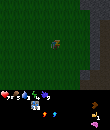

In [42]:
o = agent.wm.obs_model.decode(dreamer.prev_z)
from PIL import ImageDraw
from twm import utils
from einops import rearrange
from twm.envs.craftax import craftax_symobs_to_img
img = craftax_symobs_to_img(o.detach(), env.unwrapped.env_state).squeeze(2)[0][0][-1]
img = rearrange(img, 'h w c -> c h w') / 255.0
recon_img = utils.to_image(img)
recon_img

torch.Size([130, 110, 3])

## Scratch

## Torchinfo

In [ ]:
from torchinfo import summary

agent.wm
agent.ac

batch_size = 16
summary(model, input_size=(batch_size, 1, 28, 28))

In [ ]:
wm = trainer.agent.wm
obs_model = wm.obs_model
dyn_model = wm.dyn_model

wm.eval()
with torch.no_grad():
    context_z_dist = obs_model.encode(o[:, :1])
    context_z = obs_model.sample_z(context_z_dist)
    next_z_dist = obs_model.encode(o[:, -1:])
    next_logits = next_z_dist.base_dist.logits
    
z_dist = obs_model.encode(o)
z = obs_model.sample_z(z_dist, reparameterized=True)
recons = obs_model.decode(z)

# dynamics model
z = z.detach()
z = torch.cat([context_z, z], dim=1)
d = torch.logical_or(terminated, truncated)
g = wm.to_discounts(terminated)

tgt_length = z.shape[1]

preds, h, mems = dyn_model.predict(
    z, a, r[:, :-1], g[:, :-1], d[:, :-1], tgt_length, compute_consistency=True
)